In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from datetime import datetime 

In [5]:
import boto3
import pandas as pd
from sagemaker import get_execution_role

role = get_execution_role()
bucket='noshows3'
data_key = 'df_clean.csv'
data_location = 's3://{0}/{1}'.format(bucket, data_key)
df = pd.read_csv(data_location)

In [6]:
df=df.drop(['Unnamed: 0'], axis=1)
df=df.set_index(['PatientId', 'AppointmentID'])
df.head(1)

,,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,appointmentDay,scheduledDay,Interval,Period
PatientId,AppointmentID,,,,,,,,,,,,,,,,
2.987250e+13,5642903,F,2016-04-29 18:38:08,2016-04-29 00:00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No,Friday,Friday,0,Afternoon


In [7]:
df_mask=df['Interval']<=58
filtered_df=df[df_mask]
print(len(df))
print(len(filtered_df))
print(filtered_df['Interval'].quantile(1))

110526
108358
58.0


In [9]:
pip install sklearn-pandas

Note: you may need to restart the kernel to use updated packages.


In [10]:
# https://machinelearningmastery.com/how-to-prepare-categorical-data-for-deep-learning-in-python/
# code partially inspired from above 
# The best practice when encoding variables is to fit the encoding on the training dataset, 
# then apply it to the train and test datasets.

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper

def encode_categorical_cols(dataframe):
    categorical_columns = dataframe.select_dtypes(include=['object', 'category']).columns
    numerical_columns = dataframe.select_dtypes(include=['float64', 'int64']).columns

    mapping = []
    mapping += ((col, LabelEncoder()) for col in categorical_columns)
    mapping += ((col, None) for col in numerical_columns)
        
    mapper = DataFrameMapper(mapping, df_out=True)
    
    stages = []
    stages += [("pre_processing_mapper", mapper)]
    
    pipeline = Pipeline(stages)
    transformed_df = pipeline.fit_transform(dataframe)
    return transformed_df

encoded_data = encode_categorical_cols(filtered_df)
encoded_data.dtypes

Gender            int64
ScheduledDay      int64
AppointmentDay    int64
Neighbourhood     int64
No-show           int64
appointmentDay    int64
scheduledDay      int64
Period            int64
Age               int64
Scholarship       int64
Hipertension      int64
Diabetes          int64
Alcoholism        int64
Handcap           int64
SMS_received      int64
Interval          int64
dtype: object

In [11]:
#X Data
X = encoded_data.drop(['No-show'], axis = 1, inplace = False)

#y Data
y = encoded_data['No-show']

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 191, shuffle=True)

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

## Establish exhaustive gri search 
# https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

forest = RandomForestClassifier(random_state = 191)

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(forest, hyperF, cv = None, verbose = 2, 
                      n_jobs = -1) #None to use default 5-fold cross validation 
bestF = gridF.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [37]:
pip install yellowbrick

     |████████████████████████████████| 271 kB 6.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


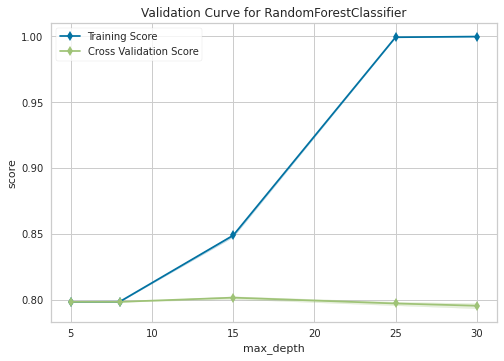

ValidationCurve(ax=<AxesSubplot:title={'center':'Validation Curve for RandomForestClassifier'}, xlabel='max_depth', ylabel='score'>,
                cv=5,
                estimator=RandomForestClassifier(n_estimators=800,
                                                 random_state=191),
                param_name='max_depth', param_range=array([ 5,  8, 15, 25, 30]),
                scoring='accuracy')


In [39]:
# https://towardsdatascience.com/validation-curve-explained-plot-the-influence-of-a-single-hyperparameter-1ac4864deaf8
# https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6

from yellowbrick.model_selection import validation_curve 

rf = RandomForestClassifier(random_state=191, n_estimators = 800, min_samples_split=2, min_samples_leaf=1)

print(validation_curve(rf, #from below borrwing optimal params 
                                X = X_train, y = y_train, 
                                param_name = 'max_depth', 
                                param_range = max_depth , cv = 5, scoring='accuracy'))

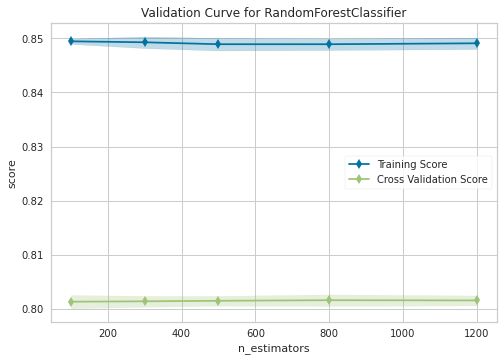

ValidationCurve(ax=<AxesSubplot:title={'center':'Validation Curve for RandomForestClassifier'}, xlabel='n_estimators', ylabel='score'>,
                cv=5,
                estimator=RandomForestClassifier(max_depth=15,
                                                 random_state=191),
                param_name='n_estimators',
                param_range=array([ 100,  300,  500,  800, 1200]),
                scoring='accuracy')


In [40]:
rf = RandomForestClassifier(random_state=191, max_depth=15, min_samples_split=2, min_samples_leaf=1)

print(validation_curve(rf, #from below borrwing optimal params 
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                                param_range = n_estimators , cv = 5, scoring='accuracy'))

In [17]:
print(bestF.best_params_, bestF.best_score_)

{'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800} 0.8016363700874904


In [19]:
bestF.cv_results_

{'mean_fit_time': array([  3.65418558,  10.95642462,  18.34690013,  29.0332067 ,
         43.59296417,   3.68672085,  11.1168581 ,  18.36193676,
         29.06397662,  43.76934195,   3.69035187,  11.03937731,
         18.23655338,  28.90824137,  43.64127016,   3.67408037,
         10.9828979 ,  18.33322906,  29.01909933,  43.77132769,
          3.69397349,  11.21657357,  18.23763509,  28.91091824,
         43.68676662,   3.65866566,  11.0176024 ,  18.03288202,
         28.90953741,  43.50981064,   3.66675019,  10.83797622,
         18.0522717 ,  29.05497823,  43.56046991,   3.66603446,
         10.93913665,  18.23506207,  29.065274  ,  43.55011773,
          3.66115403,  10.8840405 ,  18.03639092,  28.80876722,
         43.63631439,   3.66807737,  10.98200464,  18.46778083,
         29.13915348,  43.41137962,   3.68329835,  10.88387413,
         18.18088298,  28.81770411,  43.47683744,   3.65443015,
         11.0519145 ,  18.27881231,  28.80263324,  43.37870092,
          3.6146656 ,  

In [22]:
bestF.best_index_

203

In [23]:
bestF.scorer_

<function sklearn.metrics._scorer._passthrough_scorer(estimator, *args, **kwargs)>

In [30]:
forestOpt = RandomForestClassifier(random_state = 191, max_depth = 15,     
n_estimators = 800, min_samples_split = 2, min_samples_leaf = 1)

modelOpt = forestOpt.fit(X_train, y_train)
y_pred = forestOpt.predict(X_test)

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [32]:
#Calculating Confusion Matrix
Confusion_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix is : \n', Confusion_matrix)
print('')

#Calculating Accuracy Score  : ((TP + TN) / float(TP + TN + FP + FN))
Accuracy_score = accuracy_score(y_test, y_pred)
print('Accuracy Score is : ', Accuracy_score)
print('')

#Calculating Recall Score : (Sensitivity) (TP / float(TP + FN))  
Recall_score = recall_score(y_test, y_pred, average = 'micro')
print('Recall Score is : ', Recall_score)
print('')

#Calculating Precision Score : (Specificity) #(TP / float(TP + FP))  
Precision_score = precision_score(y_test, y_pred, average = 'micro') 
print('Precision Score is : ', Precision_score)



Confusion Matrix is : 
 [[28595   106]
 [ 6775   283]]

Accuracy Score is :  0.8075729187057804

Recall Score is :  0.8075729187057804

Precision Score is :  0.8075729187057804
